In [1]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from tqdm import tqdm

class DeepFakeDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = models.resnet50(pretrained=True)
        self.cnn.fc = nn.Identity()  # Remove final FC layer
        self.rnn = nn.LSTM(input_size=2048, hidden_size=128, batch_first=True)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        # x: (batch_size, seq_len, C, H, W)
        # print(x.shape)
        batch_size, seq_len = x.size(0), x.size(1)
        cnn_features = []
        for i in range(seq_len):
            features = self.cnn(x[:, i, :, :, :])  # (batch_size, 2048)
            cnn_features.append(features)
        cnn_features = torch.stack(cnn_features, dim=1)  # (batch_size, seq_len, 2048)
        _, (hidden, _) = self.rnn(cnn_features)
        output = self.fc(hidden[-1])
        return torch.sigmoid(output)


In [2]:
import os
import pandas as pd
import torch
import torchvision
from torch.utils.data import Dataset
from PIL import Image


class SingleVideoDataset(Dataset):
    def __init__(self, video_folder, label, transform=None):
        """
        Args:
            video_folder (str): Path to the folder containing frames of a single video.
            label (int/str): Label for the video.
            transform (callable, optional): Optional transform to be applied on each frame.
        """
        self.video_folder = video_folder
        self.label = label
        self.frame_paths = sorted([os.path.join(video_folder, f) for f in os.listdir(video_folder)])
        self.transform = transform

    def __len__(self):
        # Return 1 because each instance is a whole video (sequence of frames)
        return 1

    def __getitem__(self, idx):
        # Load all frames in the video folder
        frames = []
        for img_path in self.frame_paths:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            frames.append(image)
        # Stack frames into a single tensor (T, C, H, W)
        frames = torch.stack(frames, dim=0)
        return frames, self.label
    

from sklearn.model_selection import train_test_split

class AllVideosDataset(Dataset):
    def __init__(self, root_dir, video_ids, labels, transform=None):
        """
        Args:
            root_dir (str): Directory with all video folders.
            video_ids (list): List of video IDs for this split.
            labels (list): Corresponding labels for each video.
            transform (callable, optional): Optional transform to be applied on each frame.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.video_datasets = []
        no_data_videos = []
        
        for video_id, label in zip(video_ids, labels):
            video_folder = os.path.join(root_dir, "images_successive", f"{video_id}")
            if os.path.exists(video_folder) and os.listdir(video_folder):
                self.video_datasets.append(SingleVideoDataset(video_folder, label, transform))
            else:
                no_data_videos.append(video_id)
        
        if no_data_videos:
            print(f"Warning: No data found for {len(no_data_videos)} videos.")

    def __len__(self):
        return len(self.video_datasets)

    def __getitem__(self, idx):
        return self.video_datasets[idx][0]


In [3]:
def get_train_val_datasets(root_dir, metadata_path, transform=None, val_size=0.2, random_state=42):
    """
    Create and return train and validation datasets.
    
    Args:
        root_dir (str): Directory with all video folders.
        metadata_path (str): Path to the CSV file with video_id and label.
        transform (callable, optional): Optional transform to be applied on each frame.
        val_size (float): Proportion of data to use for validation (default: 0.2).
        random_state (int): Random seed for reproducibility (default: 42).
    
    Returns:
        tuple: (train_dataset, val_dataset)
    """
    # Load and split metadata once
    metadata = pd.read_csv(metadata_path)
    train_df, val_df = train_test_split(metadata, test_size=val_size, random_state=random_state)
    
    # Create datasets with pre-split data
    train_dataset = AllVideosDataset(
        root_dir=root_dir,
        video_ids=train_df['video_id'].tolist(),
        labels=train_df['label'].tolist(),
        transform=transform
    )
    
    val_dataset = AllVideosDataset(
        root_dir=root_dir,
        video_ids=val_df['video_id'].tolist(),
        labels=val_df['label'].tolist(),
        transform=transform
    )
    
    return train_dataset, val_dataset


In [4]:
class CollateFn:
    def __init__(self, pad_value=0, max_frames=None):
        self.pad_value = pad_value
        self.max_frames = max_frames

    def __call__(self, batch):
        frames, labels = zip(*batch)
        if self.max_frames is not None:
            frames = [f[:self.max_frames] if f.shape[0] > self.max_frames else f for f in frames]
        max_frames = max(f.shape[0] for f in frames)
        padded_frames = torch.stack([
            F.pad(f, (0, 0, 0, 0, 0, 0, 0, max_frames - f.shape[0]), value=self.pad_value)
            for f in frames
        ])
        return padded_frames, torch.tensor(labels)



In [5]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create train and validation datasets
train_dataset, val_dataset = get_train_val_datasets(
    root_dir='data',
    metadata_path='data/metadata2.csv',
    transform=transform,
    val_size=0.2,
    random_state=42
)

print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')


Train dataset size: 1600
Validation dataset size: 400


In [6]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=CollateFn(max_frames=8))
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=CollateFn(max_frames=8))

print(f'Total samples in train dataset: {len(train_dataset)}')
print(f'Total samples in validation dataset: {len(val_dataset)}')
first_batch = next(iter(train_dataloader))
print(f'First batch shape: {first_batch[0].shape}')


Total samples in train dataset: 1600
Total samples in validation dataset: 400
First batch shape: torch.Size([4, 8, 3, 224, 224])


In [7]:
# training setup
model = DeepFakeDetector()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f'using device {device}')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCELoss()

# Track metrics for plotting
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_iter = tqdm(train_dataloader, desc=f'Epoch [{epoch+1}/{num_epochs}] Train')
    train_loss = 0.0
    for images, labels in epoch_iter:
        optimizer.zero_grad()
        outputs = model(images.to(device))
        loss = criterion(outputs.squeeze(), labels.float().to(device))
        loss_value = loss.item()
        train_loss += loss_value
        epoch_iter.set_postfix({'loss': f'{loss_value:.4f}'})
        loss.backward()
        optimizer.step()
    
    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        val_iter = tqdm(val_dataloader, desc=f'Epoch [{epoch+1}/{num_epochs}] Val')
        for images, labels in val_iter:
            outputs = model(images.to(device))
            loss = criterion(outputs.squeeze(), labels.float().to(device))
            val_loss += loss.item()
            predictions = (outputs.squeeze() > 0.5).long()
            correct += (predictions.cpu() == labels).sum().item()
            total += labels.size(0)
            val_iter.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')


c:\Users\lorra\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lorra\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


using device cuda


Epoch [1/10] Val: 100%|██████████| 100/100 [00:24<00:00,  4.00it/s, loss=0.3800]


Epoch [1/10] - Train Loss: 0.4186, Val Loss: 0.1662, Val Acc: 94.75%


Epoch [2/10] Val: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s, loss=0.2704]


Epoch [2/10] - Train Loss: 0.2678, Val Loss: 0.2879, Val Acc: 87.50%


Epoch [3/10] Val: 100%|██████████| 100/100 [00:26<00:00,  3.73it/s, loss=0.1433]


Epoch [3/10] - Train Loss: 0.2181, Val Loss: 0.0832, Val Acc: 98.50%


Epoch [4/10] Val: 100%|██████████| 100/100 [00:21<00:00,  4.56it/s, loss=0.0556]


Epoch [4/10] - Train Loss: 0.1650, Val Loss: 0.2346, Val Acc: 90.00%


Epoch [5/10] Val: 100%|██████████| 100/100 [00:20<00:00,  4.90it/s, loss=0.0369]


Epoch [5/10] - Train Loss: 0.1226, Val Loss: 0.0606, Val Acc: 97.75%


Epoch [6/10] Val: 100%|██████████| 100/100 [00:20<00:00,  4.81it/s, loss=0.0989]


Epoch [6/10] - Train Loss: 0.1111, Val Loss: 0.0424, Val Acc: 98.75%


Epoch [7/10] Val: 100%|██████████| 100/100 [00:20<00:00,  4.86it/s, loss=0.0998]


Epoch [7/10] - Train Loss: 0.0909, Val Loss: 0.0367, Val Acc: 99.50%


Epoch [8/10] Val: 100%|██████████| 100/100 [00:21<00:00,  4.70it/s, loss=0.0538]


Epoch [8/10] - Train Loss: 0.0685, Val Loss: 0.0706, Val Acc: 97.25%


Epoch [9/10] Val: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s, loss=0.0765]


Epoch [9/10] - Train Loss: 0.0711, Val Loss: 0.3429, Val Acc: 89.25%


Epoch [10/10] Val: 100%|██████████| 100/100 [00:25<00:00,  3.91it/s, loss=0.0201]

Epoch [10/10] - Train Loss: 0.0415, Val Loss: 0.1514, Val Acc: 92.50%


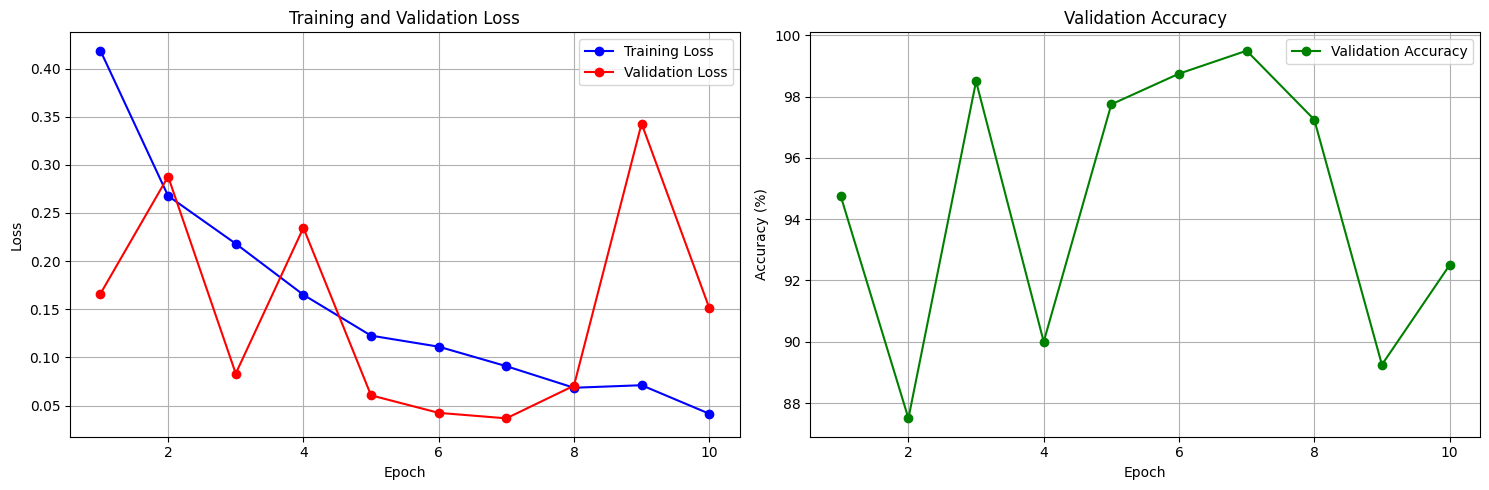

In [8]:
# Plot training curves
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot losses
epochs_range = range(1, len(train_losses) + 1)
ax1.plot(epochs_range, train_losses, 'b-', label='Training Loss', marker='o')
ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss', marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot validation accuracy
ax2.plot(epochs_range, val_accuracies, 'g-', label='Validation Accuracy', marker='o')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [9]:
# save model
torch.save(model.state_dict(), 'deepfake_detector.pth')

Predictions: [0 1 1 1]
Ground Truth: [0 1 1 1]
Batch shape: torch.Size([4, 8, 3, 224, 224])


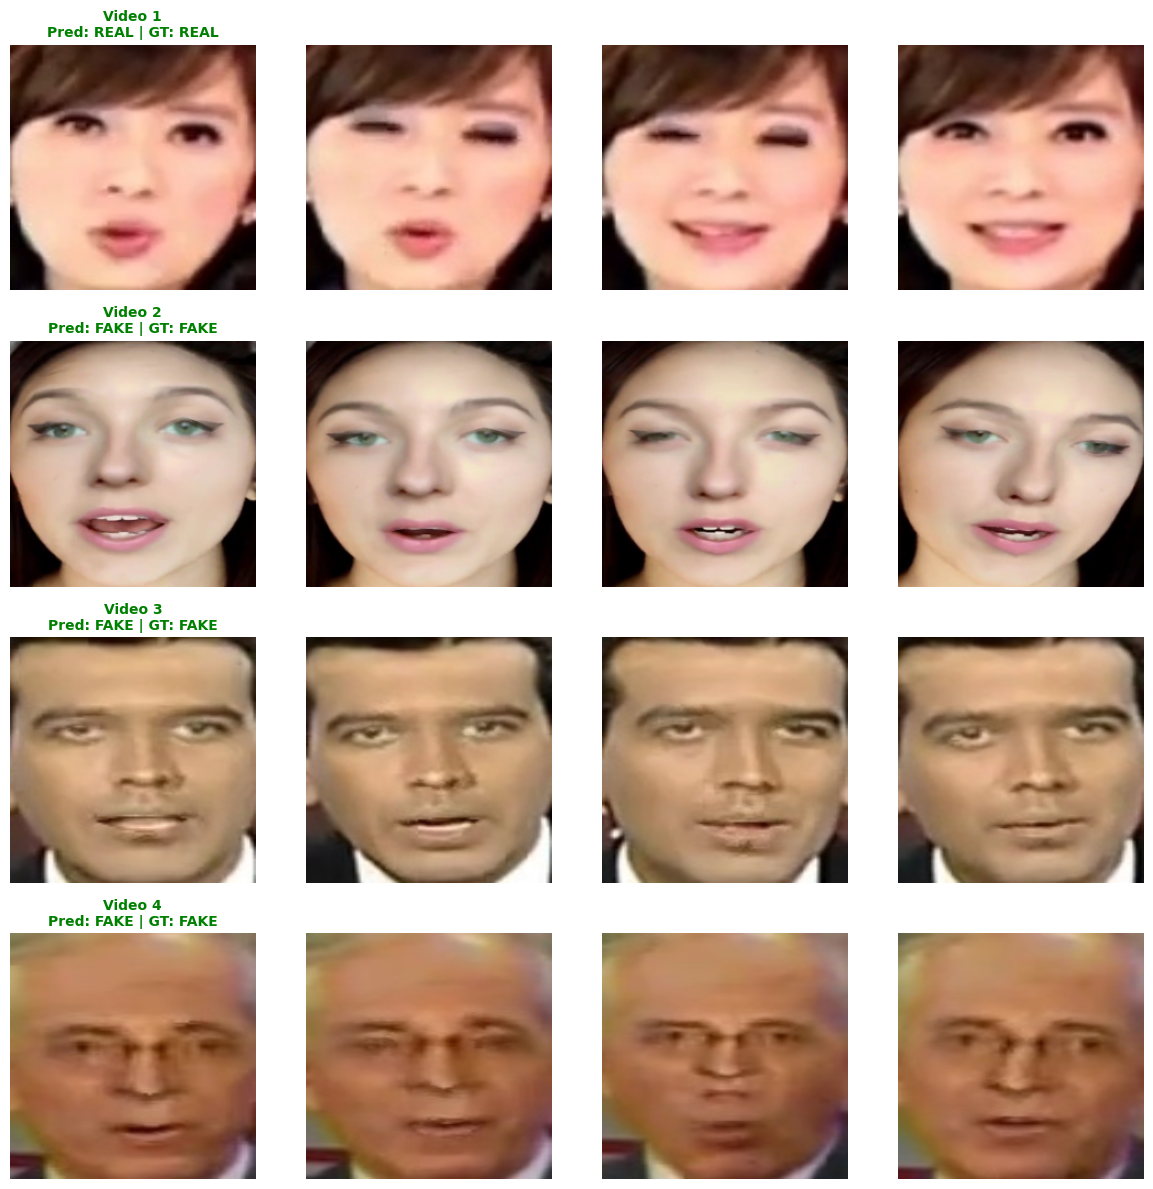

In [10]:
# inference example on validation set
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for images, labels in val_dataloader:
        outputs = model(images.to(device))
        predictions = (outputs.squeeze() > 0.5).long()
        print(f'Predictions: {predictions.cpu().numpy()}')
        print(f'Ground Truth: {labels.numpy()}')
        print(f'Batch shape: {images.shape}')  # (B, T, C, H, W)
        
        # Display one frame from each video in the batch
        batch_size = images.shape[0]
        num_frames_to_show = min(4, images.shape[1])  # Show up to 4 frames per video
        
        fig, axes = plt.subplots(batch_size, num_frames_to_show, figsize=(num_frames_to_show * 3, batch_size * 3))
        
        # Handle case when batch_size is 1
        if batch_size == 1:
            axes = axes.reshape(1, -1)
        
        for video_idx in range(batch_size):
            for frame_idx in range(num_frames_to_show):
                # Unnormalize the image
                img = images[video_idx][frame_idx]
                img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                img = torch.clamp(img, 0, 1)  # Clamp to valid range
                
                axes[video_idx, frame_idx].imshow(img.permute(1, 2, 0).cpu())
                axes[video_idx, frame_idx].axis('off')
                
                # Add title to first frame of each video
                if frame_idx == 0:
                    pred_label = "FAKE" if predictions[video_idx].item() == 1 else "REAL"
                    gt_label = "FAKE" if labels[video_idx].item() == 1 else "REAL"
                    color = 'green' if predictions[video_idx].item() == labels[video_idx].item() else 'red'
                    axes[video_idx, frame_idx].set_title(
                        f'Video {video_idx+1}\nPred: {pred_label} | GT: {gt_label}',
                        fontsize=10, fontweight='bold', color=color
                    )
        
        plt.tight_layout()
        plt.show()
        
        break


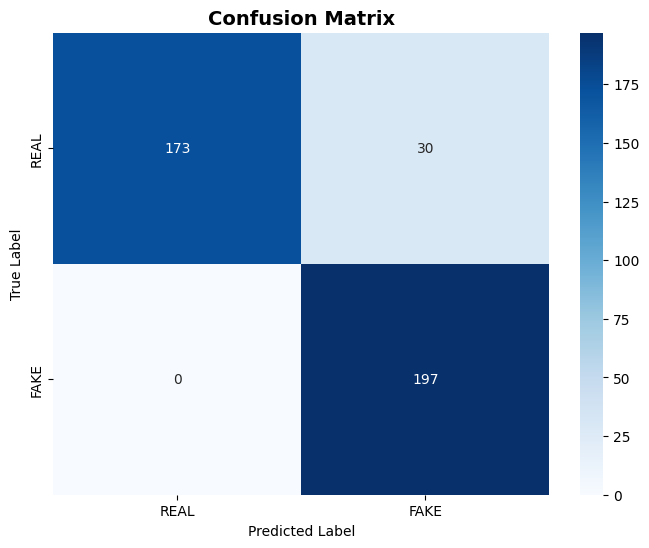


PERFORMANCE METRICS
Precision: 0.8678
Recall:    1.0000
F1-Score:  0.9292
PR AUC:    0.9985

Detailed Classification Report:
              precision    recall  f1-score   support

        REAL       1.00      0.85      0.92       203
        FAKE       0.87      1.00      0.93       197

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.92       400
weighted avg       0.93      0.93      0.92       400



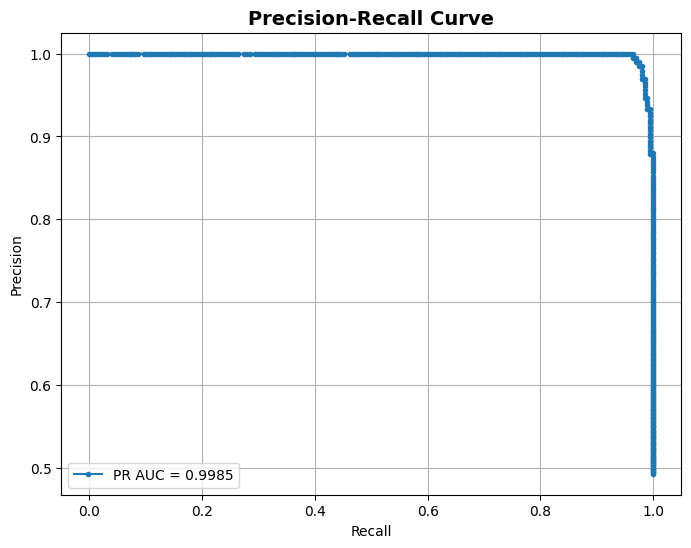

In [12]:
# Evaluate model with detailed metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc, precision_score, recall_score, f1_score
import numpy as np
import seaborn as sns

model.eval()
all_predictions = []
all_labels = []
all_probabilities = []

with torch.no_grad():
    for images, labels in val_dataloader:
        outputs = model(images.to(device))
        probabilities = outputs.squeeze().cpu().numpy()
        predictions = (outputs.squeeze() > 0.5).long().cpu().numpy()
        
        all_predictions.extend(predictions)
        all_labels.extend(labels.numpy())
        all_probabilities.extend(probabilities)

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
all_probabilities = np.array(all_probabilities)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['REAL', 'FAKE'], 
            yticklabels=['REAL', 'FAKE'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate metrics
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# PR AUC
precision_curve, recall_curve, _ = precision_recall_curve(all_labels, all_probabilities)
pr_auc = auc(recall_curve, precision_curve)

# Print metrics
print("\n" + "="*50)
print("PERFORMANCE METRICS")
print("="*50)
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"PR AUC:    {pr_auc:.4f}")
print("="*50)

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=['REAL', 'FAKE']))

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, marker='.', label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()
